In [22]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb
from tpot import TPOTClassifier

In [23]:
features_num = [
    'Total_flux', 'Peak_flux', 
       'NUV_flux_corr', 'FUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 'R_flux_corr',
       'I_flux_corr', 'z_flux_corr', 'y_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 'Ks_flux_corr',
       'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'Z_BEST',
       'g_flux_corr', 'nb921_hsc_flux_corr',
    ]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

In [24]:
data = pd.read_csv("../../../Data/Fangyou_data/Cleaned/combined_using_similar_columns.csv")
data['Source'] = 'Original'

In [25]:
list(data.columns)

['Source_Name',
 'RA',
 'DEC',
 'Total_flux',
 'E_Total_flux',
 'Peak_flux',
 'E_Peak_flux',
 'S_Code',
 'EBV',
 'FUV_flux_corr',
 'FUV_fluxerr_corr',
 'NUV_flux_corr',
 'NUV_fluxerr_corr',
 'u_flux_corr',
 'u_fluxerr_corr',
 'Bw_flux_corr',
 'Bw_fluxerr_corr',
 'R_flux_corr',
 'R_fluxerr_corr',
 'I_flux_corr',
 'I_fluxerr_corr',
 'z_flux_corr',
 'z_fluxerr_corr',
 'z_Subaru_flux_corr',
 'z_Subaru_fluxerr_corr',
 'y_flux_corr',
 'y_fluxerr_corr',
 'J_flux_corr',
 'J_fluxerr_corr',
 'H_flux_corr',
 'H_fluxerr_corr',
 'K_flux_corr',
 'K_fluxerr_corr',
 'Ks_flux_corr',
 'Ks_fluxerr_corr',
 'ch1_flux_corr',
 'ch1_fluxerr_corr',
 'ch2_flux_corr',
 'ch2_fluxerr_corr',
 'ch3_flux_corr',
 'ch3_fluxerr_corr',
 'ch4_flux_corr',
 'ch4_fluxerr_corr',
 'F_MIPS_24',
 'FErr_MIPS_24_u',
 'FErr_MIPS_24_l',
 'F_PACS_100',
 'FErr_PACS_100_u',
 'FErr_PACS_100_l',
 'F_PACS_160',
 'FErr_PACS_160_u',
 'FErr_PACS_160_l',
 'F_SPIRE_250',
 'FErr_SPIRE_250_u',
 'FErr_SPIRE_250_l',
 'F_SPIRE_350',
 'FErr_SPIRE_35

In [26]:
X = data[features_num]
y = data[[y_column, 'Source', 'Xray', 'Opt_spec', 'IRAGN', 'Donley']]

In [27]:
le = LabelEncoder()
labels = np.unique(y["Classification"].astype(str))
y["Classification"] = le.fit_transform(y["Classification"])

/var/lib/condor/execute/dir_9432/ipykernel_10706/2943677748.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["Classification"] = le.fit_transform(y["Classification"])


In [28]:
# -1 in the LOFAR deep fields should become nans since they are factually nans
for c in ['Xray', 'Opt_spec', 'IRAGN', 'Donley']:
    y[c][y[c]==-1]=np.nan
    y[c][y[c] == 1] = True
    y[c][y[c] == 0] = False

/var/lib/condor/execute/dir_9432/ipykernel_10706/975002904.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[c][y[c]==-1]=np.nan
/var/lib/condor/execute/dir_9432/ipykernel_10706/975002904.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[c][y[c] == 1] = True
/var/lib/condor/execute/dir_9432/ipykernel_10706/975002904.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[c][y[c] == 0] = False


## BH data

In [29]:
Best_Heckman_data = pd.read_csv("../../../Data/Best&Heckman/BestHeckman+SDSS+wise+LOFAR_better_fixed_fluxes.csv")
Best_Heckman_data['Source'] = 'BH'

In [30]:
# Only selecting data with a classification
Best_Heckman_data = Best_Heckman_data[Best_Heckman_data['Classification'] != 'Radio-loud AGN'] 

In [31]:
Best_Heckman_X = Best_Heckman_data[[c for c in Best_Heckman_data.columns if c != 'Classification']]
Best_Heckman_y = Best_Heckman_data[['Classification', 'Source']]

In [32]:
Best_Heckman_y['Classification'] = le.transform(Best_Heckman_y['Classification'])

/var/lib/condor/execute/dir_9432/ipykernel_10706/4234724966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Best_Heckman_y['Classification'] = le.transform(Best_Heckman_y['Classification'])


In [33]:
y = pd.concat([y, Best_Heckman_y]).reset_index(drop=True)

In [34]:
Best_Heckman_X = Best_Heckman_X[['Z_BEST', 'u_flux_corr',
       'g_flux_corr', 'R_flux_corr', 'I_flux_corr', 'z_flux_corr', 'ch1_flux_corr', 'ch2_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'Ks_flux_corr', 'Peak_flux', 'Total_flux']]

# Adding nans to missing columns
Best_Heckman_X[['NUV_flux_corr', 'Bw_flux_corr', 'y_flux_corr', 'K_flux_corr', 
                'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
                'F_SPIRE_500', 'nb921_hsc_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr', 'FUV_flux_corr']] = np.nan

In [35]:
X = pd.concat([X, Best_Heckman_X]).reset_index(drop=True)

### MIGHTEE data

In [36]:
mightee_data = pd.read_csv("../../../Data/MIGHTEE/Classification/final_gaussian_radio_more.csv")
mightee_data['Source'] = 'MIGHTEE'

In [37]:
# Dropping nan classifications
mightee_data = mightee_data[mightee_data['Classification'].notna()]

# Dropping quasar-like radio AGN / high-excitation radio galaxy
#mightee_data = mightee_data[mightee_data['Classification'] != 'star-forming galaxy']
print("Amount of rows:", len(mightee_data))

Amount of rows: 4370


In [38]:
mightee_X = mightee_data[[c for c in mightee_data.columns if c != 'Classification']]
mightee_y = mightee_data[['Classification', 'Source', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN']]

In [39]:
mightee_y['Classification'] = le.transform(mightee_y['Classification'])
y = pd.concat([y, mightee_y]).reset_index(drop=True)

/var/lib/condor/execute/dir_9432/ipykernel_10706/4111256676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mightee_y['Classification'] = le.transform(mightee_y['Classification'])


In [40]:
mightee_X = mightee_X[['Z_BEST', 'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr',
       'ch4_flux_corr', 'F_MIPS_24', 'F_PACS_100', 'F_PACS_160',
       'F_SPIRE_250', 'F_SPIRE_350', 'F_SPIRE_500', 'Ks_flux_corr',
       'H_flux_corr', 'J_flux_corr', 'i_flux_corr', 'r_flux_corr',
       'u_flux_corr', 'z_flux_corr', 'y_flux_corr', 'NUV_flux_corr',
       'FUV_flux_corr', 
                       'Total_flux', 'Peak_flux']]

mightee_X[['I_flux_corr', 'R_flux_corr']] = mightee_X[['i_flux_corr', 'r_flux_corr']]
mightee_X = mightee_X.drop(columns=['i_flux_corr', 'r_flux_corr'])

# Adding nans to missing columns
mightee_X[['Bw_flux_corr', 'K_flux_corr', 'g_flux_corr', 'nb921_hsc_flux_corr']] = np.nan

# Changing order
mightee_X = mightee_X[['Total_flux', 'Peak_flux', 
                       'NUV_flux_corr', 'u_flux_corr', 
                       'Bw_flux_corr', 'R_flux_corr', 
                       'I_flux_corr', 'z_flux_corr', 
                       'y_flux_corr', 'J_flux_corr', 
                       'H_flux_corr', 'K_flux_corr', 
                       'Ks_flux_corr', 'ch1_flux_corr', 
                       'ch2_flux_corr', 'ch3_flux_corr', 
                       'ch4_flux_corr', 'F_MIPS_24', 'F_PACS_100', 
                       'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350', 
                       'F_SPIRE_500', 'Z_BEST', 
                       'g_flux_corr', 'nb921_hsc_flux_corr']]

In [41]:
X = pd.concat([X, mightee_X]).reset_index(drop=True)

### Generate more features

In [21]:
X['ch1/ch2'] = X['ch1_flux_corr']/X['ch2_flux_corr']
X['ch2/ch3'] = X['ch2_flux_corr']/X['ch3_flux_corr']
X['ch3/ch4'] = X['ch3_flux_corr']/X['ch4_flux_corr']
X['ch3/ch4'] = X['ch3_flux_corr']/X['ch4_flux_corr']
X['r/J'] = X['R_flux_corr']/X['J_flux_corr']
X['u/r'] = X['u_flux_corr']/X['R_flux_corr']
X['g/r'] = X['g_flux_corr']/X['R_flux_corr']

## AutoML

In [21]:
from flaml import AutoML
automl = AutoML()

In [24]:
import warnings

X_train, X_test, y_train, y_test = train_test_split(X, y['Classification'], train_size=0.8, stratify=y[['Source', 'Classification']], random_state=42)

estimators = ['xgb_limitdepth']
#estimators = ['extra_tree']

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    automl.fit(X_train, y_train, task="classification", metric='accuracy',
                                #X_val=X_val , y_val=y_val,
                                #ensemble=True,
                                #estimator_list=estimators, 
                                time_budget=3600, n_jobs=8,
                                eval_method='cv',
                                #log_file_name='general_extra_features3.log',
                                #starting_points=automl.best_config_per_estimator
              )

[flaml.automl: 02-03 13:40:07] {2390} INFO - task = classification
[flaml.automl: 02-03 13:40:07] {2392} INFO - Data split method: stratified
[flaml.automl: 02-03 13:40:07] {2396} INFO - Evaluation method: cv
[flaml.automl: 02-03 13:40:07] {2465} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 02-03 13:40:07] {2605} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 02-03 13:40:07] {2897} INFO - iteration 0, current learner lgbm
[flaml.automl: 02-03 13:40:08] {3025} INFO - Estimated sufficient time budget=12343s. Estimated necessary time budget=285s.
[flaml.automl: 02-03 13:40:08] {3072} INFO -  at 1.8s,	estimator lgbm's best error=0.2569,	best estimator lgbm's best error=0.2569
[flaml.automl: 02-03 13:40:08] {2897} INFO - iteration 1, current learner lgbm
[flaml.automl: 02-03 13:40:09] {3072} INFO -  at 3.0s,	estimator lgbm's best error=0.2569,	best estimator lgbm's best error=0.2569
[flaml.automl: 02-03

[flaml.automl: 02-03 13:42:49] {2897} INFO - iteration 36, current learner xgboost
[flaml.automl: 02-03 13:42:54] {3072} INFO -  at 167.4s,	estimator xgboost's best error=0.1251,	best estimator lgbm's best error=0.1097
[flaml.automl: 02-03 13:42:54] {2897} INFO - iteration 37, current learner xgboost
[flaml.automl: 02-03 13:42:56] {3072} INFO -  at 169.9s,	estimator xgboost's best error=0.1251,	best estimator lgbm's best error=0.1097
[flaml.automl: 02-03 13:42:56] {2897} INFO - iteration 38, current learner xgboost
[flaml.automl: 02-03 13:42:58] {3072} INFO -  at 171.9s,	estimator xgboost's best error=0.1251,	best estimator lgbm's best error=0.1097
[flaml.automl: 02-03 13:42:58] {2897} INFO - iteration 39, current learner xgboost
[flaml.automl: 02-03 13:43:09] {3072} INFO -  at 183.1s,	estimator xgboost's best error=0.1164,	best estimator lgbm's best error=0.1097
[flaml.automl: 02-03 13:43:09] {2897} INFO - iteration 40, current learner xgboost
[flaml.automl: 02-03 13:43:14] {3072} INF

[flaml.automl: 02-03 13:57:01] {3072} INFO -  at 1014.9s,	estimator xgb_limitdepth's best error=0.1264,	best estimator xgboost's best error=0.1071
[flaml.automl: 02-03 13:57:01] {2897} INFO - iteration 74, current learner extra_tree
[flaml.automl: 02-03 13:57:02] {3072} INFO -  at 1015.3s,	estimator extra_tree's best error=0.2524,	best estimator xgboost's best error=0.1071
[flaml.automl: 02-03 13:57:02] {2897} INFO - iteration 75, current learner xgb_limitdepth
[flaml.automl: 02-03 13:57:27] {3072} INFO -  at 1040.9s,	estimator xgb_limitdepth's best error=0.1226,	best estimator xgboost's best error=0.1071
[flaml.automl: 02-03 13:57:27] {2897} INFO - iteration 76, current learner rf
[flaml.automl: 02-03 13:57:41] {3072} INFO -  at 1055.0s,	estimator rf's best error=0.1354,	best estimator xgboost's best error=0.1071
[flaml.automl: 02-03 13:57:41] {2897} INFO - iteration 77, current learner rf
[flaml.automl: 02-03 13:57:53] {3072} INFO -  at 1067.0s,	estimator rf's best error=0.1354,	best

[flaml.automl: 02-03 14:10:06] {2897} INFO - iteration 110, current learner lrl1
[flaml.automl: 02-03 14:10:41] {3072} INFO -  at 1834.8s,	estimator lrl1's best error=0.3367,	best estimator xgboost's best error=0.1071
[flaml.automl: 02-03 14:10:41] {2897} INFO - iteration 111, current learner extra_tree
[flaml.automl: 02-03 14:10:44] {3072} INFO -  at 1837.4s,	estimator extra_tree's best error=0.1315,	best estimator xgboost's best error=0.1071
[flaml.automl: 02-03 14:10:44] {2897} INFO - iteration 112, current learner lgbm
[flaml.automl: 02-03 14:11:40] {3072} INFO -  at 1893.9s,	estimator lgbm's best error=0.1097,	best estimator xgboost's best error=0.1071
[flaml.automl: 02-03 14:11:40] {2897} INFO - iteration 113, current learner lrl1
[flaml.automl: 02-03 14:12:13] {3072} INFO -  at 1927.1s,	estimator lrl1's best error=0.3367,	best estimator xgboost's best error=0.1071
[flaml.automl: 02-03 14:12:13] {2897} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 02-03 14:1

[flaml.automl: 02-03 14:38:17] {3072} INFO -  at 3490.4s,	estimator extra_tree's best error=0.1309,	best estimator xgb_limitdepth's best error=0.1058
[flaml.automl: 02-03 14:38:17] {2897} INFO - iteration 147, current learner rf
[flaml.automl: 02-03 14:38:41] {3072} INFO -  at 3514.6s,	estimator rf's best error=0.1256,	best estimator xgb_limitdepth's best error=0.1058
[flaml.automl: 02-03 14:38:41] {2897} INFO - iteration 148, current learner rf
[flaml.automl: 02-03 14:39:19] {3072} INFO -  at 3552.7s,	estimator rf's best error=0.1250,	best estimator xgb_limitdepth's best error=0.1058
[flaml.automl: 02-03 14:39:19] {2897} INFO - iteration 149, current learner rf
[flaml.automl: 02-03 14:39:43] {3072} INFO -  at 3576.3s,	estimator rf's best error=0.1250,	best estimator xgb_limitdepth's best error=0.1058
[flaml.automl: 02-03 14:39:43] {2897} INFO - iteration 150, current learner extra_tree
[flaml.automl: 02-03 14:39:45] {3072} INFO -  at 3578.7s,	estimator extra_tree's best error=0.1309,	

In [45]:
print(classification_report(automl.predict(X_test), y_test, digits=4))

              precision    recall  f1-score   support

           0     0.8491    0.8987    0.8732      4434
           1     0.2165    0.6224    0.3213       143
           2     0.6772    0.7825    0.7261      1260
           3     0.9621    0.9093    0.9350     13192

    accuracy                         0.8963     19029
   macro avg     0.6762    0.8032    0.7139     19029
weighted avg     0.9113    0.8963    0.9021     19029



### Bayesian optimisation

In [42]:
from bayes_opt import BayesianOptimization

In [48]:
def optimise_xgboost(max_depth, 
                     reg_alpha, 
                     reg_lambda, 
                     min_child_weight, 
                     eta
                    ):
    # The algorithm gives floats, so we round them
    max_depth = int(max_depth)
    
    model = XGBClassifier(use_label_encoder=False, 
                      max_depth=max_depth, 
                      reg_alpha=reg_alpha,   
                      min_child_weight=min_child_weight, 
                      reg_lambda=reg_lambda,
                      eta=eta,
                      tree_method='hist',
                      #gpu_id=0,
                      objective='multi:softprob',
                      eval_metric =['mlogloss'],
                      nthread=8,
                      n_estimators=10**5
                      )
    
    y_preds = []
    for train_index, val_index in skf.split(X_train, y_train):    
        # Splitting up the new train and test set (from the original train set)
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[val_index]
        
        X_test_cv, X_val_cv, y_test_cv, y_val_cv = train_test_split(X_test_cv, y_test_cv, train_size=0.8, 
                                                                    stratify=y_test_cv, random_state=42)

        # Training the model
        model.fit(X_train_cv, y_train_cv, 
                    verbose=False, 
                    eval_set=[
                        (X_val_cv, y_val_cv)
                    ], 
                    early_stopping_rounds=5
                   )

        # Getting the accuracy and appending
        y_pred = model.predict(X_test_cv)
        y_preds.append(accuracy_score(y_test_cv, y_pred))
    return np.mean(y_preds)

In [49]:
# Bounded region of parameter space
pbounds = {
    'max_depth': (4, 7),
    'reg_alpha': (0, 10),
    'reg_lambda': (0, 30),
    'min_child_weight': (0, 10),
    'eta': (0.01, 0.8),
}

In [50]:
from sklearn.model_selection import StratifiedKFold

# Getting k folds for cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y['Classification'], train_size=0.8, stratify=y[['Source', 'Classification']], random_state=42)

skf = StratifiedKFold(n_splits=8)

print(skf)

StratifiedKFold(n_splits=8, random_state=None, shuffle=False)


In [51]:
optimizer = BayesianOptimization(
    f=optimise_xgboost,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

In [52]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    optimizer.maximize(
        init_points=15,
        n_iter=100,
    )

|   iter    |  target   |    eta    | max_depth | min_ch... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------
| 1         | 0.8946    | 0.3059    | 6.852     | 7.32      | 5.987     | 4.681     |
| 2         | 0.8916    | 0.1332    | 4.174     | 8.662     | 6.011     | 21.24     |



KeyboardInterrupt



## Best model

In [21]:
model = XGBClassifier(use_label_encoder=False, 
                      max_depth=5, 
                      reg_alpha=5.814,   
                      min_child_weight=5.226, 
                      reg_lambda=1.331,
                      #max_delta_step=9.844,
                      eta=0.4578,
                      tree_method='hist',
                      #gpu_id=0,
                      objective='multi:softprob',
                      eval_metric=['mlogloss', 'merror'],
                      nthread=8,
                      n_estimators=10**5,
                      random_state=42
                      )

In [22]:
# Important note here: the splitting is done in such a way that class balance AND source balance is maintained
# See y.value_counts
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y[['Source', 'Classification']], random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.8, stratify=y_test[['Source', 'Classification']], random_state=42)

In [23]:
eval_set = [(X_train, y_train['Classification']), (X_val, y_val['Classification'])]

In [24]:
from sklearn.utils.class_weight import compute_sample_weight

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train['Classification'] #provide your own target name
)

In [25]:
model.fit(X_train, y_train['Classification'], verbose=True, eval_set=eval_set, early_stopping_rounds=50, sample_weight=sample_weights)

[0]	validation_0-mlogloss:1.06341	validation_0-merror:0.26910	validation_1-mlogloss:1.06539	validation_1-merror:0.26852
[1]	validation_0-mlogloss:0.90434	validation_0-merror:0.24087	validation_1-mlogloss:0.90574	validation_1-merror:0.24094
[2]	validation_0-mlogloss:0.81311	validation_0-merror:0.23347	validation_1-mlogloss:0.81731	validation_1-merror:0.23410
[3]	validation_0-mlogloss:0.74482	validation_0-merror:0.22310	validation_1-mlogloss:0.74871	validation_1-merror:0.22438
[4]	validation_0-mlogloss:0.69590	validation_0-merror:0.21244	validation_1-mlogloss:0.69936	validation_1-merror:0.21177
[5]	validation_0-mlogloss:0.66066	validation_0-merror:0.20913	validation_1-mlogloss:0.66411	validation_1-merror:0.20809
[6]	validation_0-mlogloss:0.62972	validation_0-merror:0.20450	validation_1-mlogloss:0.63375	validation_1-merror:0.20389
[7]	validation_0-mlogloss:0.60735	validation_0-merror:0.20039	validation_1-mlogloss:0.61094	validation_1-merror:0.19942
[8]	validation_0-mlogloss:0.58887	valida

[68]	validation_0-mlogloss:0.33229	validation_0-merror:0.11494	validation_1-mlogloss:0.38763	validation_1-merror:0.14293
[69]	validation_0-mlogloss:0.33048	validation_0-merror:0.11429	validation_1-mlogloss:0.38666	validation_1-merror:0.14372
[70]	validation_0-mlogloss:0.32884	validation_0-merror:0.11353	validation_1-mlogloss:0.38578	validation_1-merror:0.14214
[71]	validation_0-mlogloss:0.32683	validation_0-merror:0.11319	validation_1-mlogloss:0.38468	validation_1-merror:0.14188
[72]	validation_0-mlogloss:0.32520	validation_0-merror:0.11273	validation_1-mlogloss:0.38350	validation_1-merror:0.14214
[73]	validation_0-mlogloss:0.32364	validation_0-merror:0.11191	validation_1-mlogloss:0.38290	validation_1-merror:0.14267
[74]	validation_0-mlogloss:0.32144	validation_0-merror:0.11113	validation_1-mlogloss:0.38172	validation_1-merror:0.14136
[75]	validation_0-mlogloss:0.31945	validation_0-merror:0.11053	validation_1-mlogloss:0.38015	validation_1-merror:0.14057
[76]	validation_0-mlogloss:0.317

[136]	validation_0-mlogloss:0.24332	validation_0-merror:0.08158	validation_1-mlogloss:0.33886	validation_1-merror:0.12769
[137]	validation_0-mlogloss:0.24227	validation_0-merror:0.08114	validation_1-mlogloss:0.33827	validation_1-merror:0.12743
[138]	validation_0-mlogloss:0.24138	validation_0-merror:0.08070	validation_1-mlogloss:0.33781	validation_1-merror:0.12743
[139]	validation_0-mlogloss:0.24025	validation_0-merror:0.08008	validation_1-mlogloss:0.33708	validation_1-merror:0.12664
[140]	validation_0-mlogloss:0.23931	validation_0-merror:0.07959	validation_1-mlogloss:0.33635	validation_1-merror:0.12585
[141]	validation_0-mlogloss:0.23864	validation_0-merror:0.07962	validation_1-mlogloss:0.33636	validation_1-merror:0.12612
[142]	validation_0-mlogloss:0.23771	validation_0-merror:0.07934	validation_1-mlogloss:0.33600	validation_1-merror:0.12743
[143]	validation_0-mlogloss:0.23701	validation_0-merror:0.07883	validation_1-mlogloss:0.33573	validation_1-merror:0.12638
[144]	validation_0-mlogl

[204]	validation_0-mlogloss:0.19308	validation_0-merror:0.06242	validation_1-mlogloss:0.31722	validation_1-merror:0.11955
[205]	validation_0-mlogloss:0.19267	validation_0-merror:0.06222	validation_1-mlogloss:0.31733	validation_1-merror:0.11902
[206]	validation_0-mlogloss:0.19207	validation_0-merror:0.06190	validation_1-mlogloss:0.31706	validation_1-merror:0.12007
[207]	validation_0-mlogloss:0.19143	validation_0-merror:0.06152	validation_1-mlogloss:0.31682	validation_1-merror:0.12112
[208]	validation_0-mlogloss:0.19089	validation_0-merror:0.06161	validation_1-mlogloss:0.31661	validation_1-merror:0.12034
[209]	validation_0-mlogloss:0.19038	validation_0-merror:0.06137	validation_1-mlogloss:0.31638	validation_1-merror:0.12034
[210]	validation_0-mlogloss:0.18977	validation_0-merror:0.06103	validation_1-mlogloss:0.31615	validation_1-merror:0.11955
[211]	validation_0-mlogloss:0.18923	validation_0-merror:0.06082	validation_1-mlogloss:0.31611	validation_1-merror:0.12060
[212]	validation_0-mlogl

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.4578,
              eval_metric=['mlogloss', 'merror'], gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.457800001, max_delta_step=0, max_depth=5,
              min_child_weight=5.226, missing=nan, monotone_constraints='()',
              n_estimators=100000, n_jobs=8, nthread=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=5.814,
              reg_lambda=1.331, scale_pos_weight=None, subsample=1,
              tree_method='hist', use_label_encoder=False,
              validate_parameters=1, ...)

In [26]:
hist = model.evals_result()

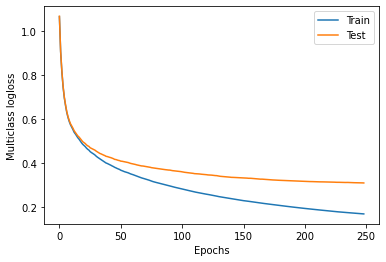

In [27]:
plt.plot(hist['validation_0']['mlogloss'], label='Train')
plt.plot(hist['validation_1']['mlogloss'], label='Test')

plt.xlabel('Epochs')
plt.ylabel('Multiclass logloss')
plt.legend()

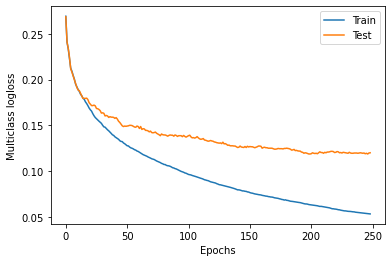

In [28]:
plt.plot(hist['validation_0']['merror'], label='Train')
plt.plot(hist['validation_1']['merror'], label='Test')

plt.xlabel('Epochs')
plt.ylabel('Multiclass logloss')
plt.legend()
#plt.ylim(0,1)

In [29]:
accuracy_score(model.predict(X_test), y_test['Classification'])

0.8746633383695723

#### Cross-validation

In [30]:
scores_subgroups = pd.DataFrame(columns=['Source', 'Accuracy', 'Precision', 'Recall', 'F1', 'Ratio'])
detection_sources = pd.DataFrame(columns=['Xray', 'Opt_spec',
       'IRAGN', 'Donley', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN'])
non_detection_sources = pd.DataFrame(columns=['Xray', 'Opt_spec',
       'IRAGN', 'Donley', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN'])

In [31]:
# We need to do a hacky trick so we can stratify over both columns
y['Combined'] = y['Classification'].astype(str) + y['Source'].astype(str)

In [32]:
# Important note here: the splitting is done in such a way that class balance AND source balance is maintained
# See y.value_counts
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y[['Source', 'Classification']], random_state=42)

In [33]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

n = 16
skf = StratifiedKFold(n_splits=n)

precisions = []
recalls = []
f1s = []
accuracies = []

# Confusion matrices
cm_all = []
cm_original = []
cm_BH = []
cm_MIGHTEE = []

# Training history data
training_histories = []

i = 0
# Important note here: the stratified k-fold is done in such a way that class balance AND source balance is maintained
# See y_train.value_counts

# We also need to convert y_train in the split to labels, but that is easily done with a label encoder
for train_index, test_index in skf.split(X_train, y_train['Combined']):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Used for early stopping
    X_test_cv, X_val_cv, y_test_cv, y_val_cv = train_test_split(X_test_cv, y_test_cv, train_size=0.8, 
                                                                stratify=y_test_cv[['Source', 'Classification']], 
                                                                random_state=42)
    
    eval_set = [(X_train_cv, y_train_cv['Classification']), 
                (X_test_cv, y_test_cv['Classification']),
                (X_val_cv, y_val_cv['Classification'])]
    model.fit(X_train_cv, y_train_cv['Classification'], verbose=False, eval_set=eval_set, early_stopping_rounds=50)
    
    # Model training history
    results = model.evals_result()
    training_histories.append(results)

    y_pred = model.predict(X_test_cv)
    
    # Confusion matrix
    cm = confusion_matrix(y_test_cv['Classification'], y_pred)
    cm_all.append(cm)
    
    # Class-specific scores
    precision = precision_score(y_test_cv['Classification'], y_pred, average=None, labels=[0, 1, 2, 3])
    recall = recall_score(y_test_cv['Classification'], y_pred, average=None, labels=[0, 1, 2, 3])
    f1 = f1_score(y_test_cv['Classification'], y_pred, average=None, labels=[0, 1, 2, 3])
    
    # General scores
    accuracy = accuracy_score(y_test_cv['Classification'], y_pred)
    
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    accuracies.append(accuracy)
    
    # New row for the (non-)detections dataframe, this is essentially a confusion matrix
    cm_row = []
    for detection in ['Xray', 'Opt_spec', 'IRAGN', 'Donley', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN']:
        sub_x_test = X_test_cv[y_test_cv[detection] == True]
        sub_y_test = y_test_cv[y_test_cv[detection] == True]
        
        y_pred = model.predict(sub_x_test)
        
        
        cm = confusion_matrix(sub_y_test['Classification'], y_pred, labels=[0, 1, 2, 3])
        cm_row.append(cm)

    newrow = pd.DataFrame(data=[cm_row], 
                          columns=['Xray', 'Opt_spec', 
                                   'IRAGN', 'Donley', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN'])

    detection_sources = pd.concat([detection_sources, newrow], ignore_index=True)
    
    cm_row = []
    for detection in ['Xray', 'Opt_spec', 'IRAGN', 'Donley', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN']:
        sub_x_test = X_test_cv[y_test_cv[detection] == False]
        sub_y_test = y_test_cv[y_test_cv[detection] == False]
        
        y_pred = model.predict(sub_x_test)
        
        
        cm = confusion_matrix(sub_y_test['Classification'], y_pred, labels=[0, 1, 2, 3])
        cm_row.append(cm)

    newrow = pd.DataFrame(data=[cm_row], 
                          columns=['Xray', 'Opt_spec', 
                                   'IRAGN', 'Donley', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN'])

    non_detection_sources = pd.concat([non_detection_sources, newrow], ignore_index=True)
    
    # Scores in subgroups
    for source in ['Original', 'BH', 'MIGHTEE']:      
        # Finding the subgroups
        sub_x_test = X_test_cv[y_test_cv['Source'] == source]
        sub_y_test = y_test_cv[y_test_cv['Source'] == source]
        
        y_pred = model.predict(sub_x_test)
        
        # Confusion matrix
        cm = confusion_matrix(sub_y_test['Classification'], y_pred)
        if source == 'Original':
            cm_original.append(cm)
        elif source == 'BH':
            cm_BH.append(cm)
        elif source == 'MIGHTEE':
            cm_MIGHTEE.append(cm)
        
        # Class-specific scores
        precision = precision_score(sub_y_test['Classification'], y_pred, average=None, zero_division=0, labels=[0, 1, 2, 3])
        recall = recall_score(sub_y_test['Classification'], y_pred, average=None, zero_division=0, labels=[0, 1, 2, 3])
        f1 = f1_score(sub_y_test['Classification'], y_pred, average=None, zero_division=0, labels=[0, 1, 2, 3])

        # General scores
        accuracy = accuracy_score(sub_y_test['Classification'], y_pred)
        
        # Ratio of sources
        ratio = sub_y_test['Classification'].value_counts()
        
        # appending row to scores dataframe
        data = [[source, accuracy, precision, recall, f1, ratio]]
        newrow = pd.DataFrame(data=data, 
                              columns=['Source', 'Accuracy', 'Precision', 'Recall', 'F1', 'Ratio'])
        
        scores_subgroups = pd.concat([scores_subgroups, newrow], ignore_index=True)
        
    
    print(f"{(i+1)/n*100}% Done")
    i+=1

6.25% Done
12.5% Done
18.75% Done
25.0% Done
31.25% Done
37.5% Done
43.75% Done
50.0% Done
56.25% Done
62.5% Done
68.75% Done
75.0% Done
81.25% Done
87.5% Done
93.75% Done
100.0% Done


In [82]:
np.array(cm_all).sum(axis=0)

array([[12796,   110,    30,  2073],
       [  507,   409,   206,   203],
       [   70,    72,  3005,  1509],
       [ 1039,    59,   680, 38112]])

In [83]:
38112/(1039+59+680+38112)

0.9554274254199048

#### Refactoring training histories list

In [34]:
training_history = pd.DataFrame(columns=['Training_mlogloss', 'Training_merror', 'Test_mlogloss', 'Test_merror'])

In [35]:
for i in range(len(training_histories)):
    hist = training_histories[i]
    hist_train = hist['validation_0']
    hist_test = hist['validation_1']
    
    iterate = np.arange(len(hist_test['mlogloss']))
    newrow = pd.DataFrame(data=np.array([iterate, hist_train['mlogloss'], hist_train['merror'], hist_test['mlogloss'], hist_test['merror']]).T,
                     columns=['Iteration', 'Training_mlogloss', 'Training_merror', 'Test_mlogloss', 'Test_merror'])

    training_history = pd.concat([training_history, newrow], ignore_index=True)

In [36]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

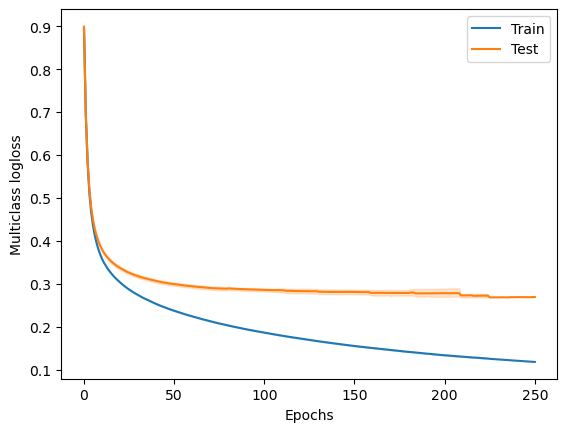

In [37]:
import seaborn as sns
sns.lineplot(data=training_history, x='Iteration', y='Training_mlogloss', label='Train')
sns.lineplot(data=training_history, x='Iteration', y='Test_mlogloss', label='Test')

plt.xlabel('Epochs')
plt.ylabel('Multiclass logloss')

plt.savefig('History_mlogloss.pdf')

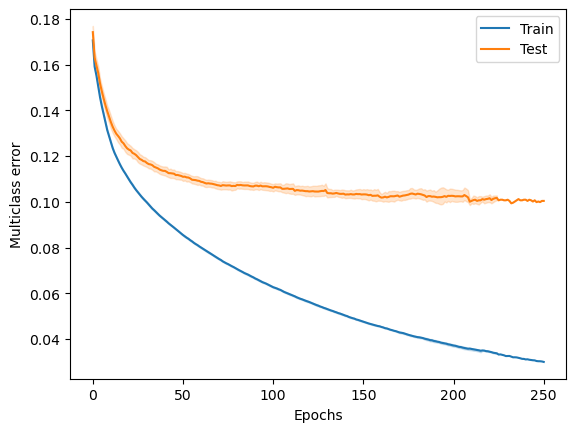

In [38]:
import seaborn as sns
sns.lineplot(data=training_history, x='Iteration', y='Training_merror', label='Train')
sns.lineplot(data=training_history, x='Iteration', y='Test_merror', label='Test')

plt.xlabel('Epochs')
plt.ylabel('Multiclass error')

plt.savefig('History_merror.pdf')

In [39]:
cm_labels = ["LERG", "HERG", "RQ", "SFG"]

## Performance for certain flags

In [40]:
for i, c in enumerate(['Xray', 'Opt_spec', 'IRAGN', 'Donley', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN']):
    print(i, c,np.nansum(y_train[c]))

0 Xray 478
1 Opt_spec 1277
2 IRAGN 4291
3 Donley 4614
4 XAGN 397
5 midIRAGN 205
6 VLBAAGN 178
7 RLAGN 936
8 optAGN 115


In [41]:
# Have to define own rounding function
def round_up(value, decimals):
    value = value * 10**decimals
    value = np.ceil(value)
    return value/10**decimals

First detection technique: optAGN with sample size: 96
Accuracy: 0.3958333333333333


invalid value encountered in true_divide
invalid value encountered in true_divide


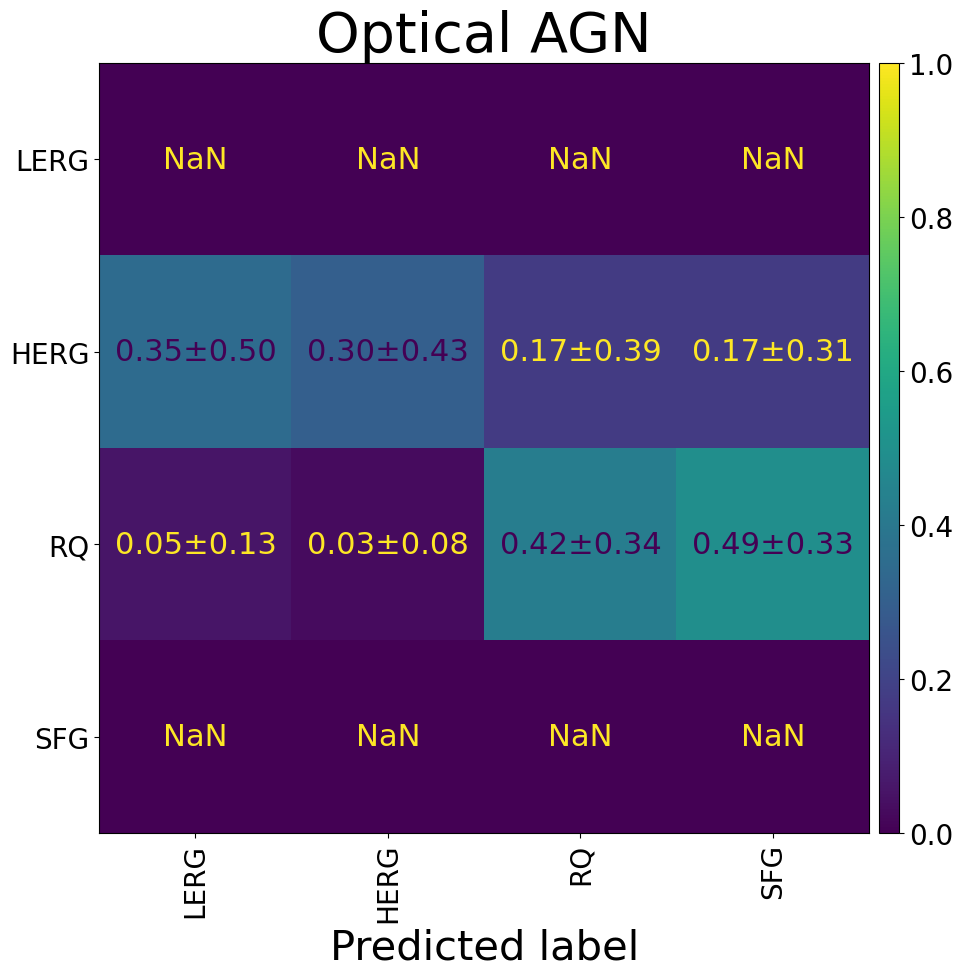

In [73]:
from matplotlib.colors import Normalize

# Can compare relative performance of 2 detection techniques
i = 8
print(f'First detection technique: {detection_sources.columns[i]} with sample size: {detection_sources.iloc[:,i].sum().sum()}')
print(f'Accuracy: {np.trace(detection_sources.sum(axis=0).iloc[i])/detection_sources.sum(axis=0).iloc[i].sum()}')

cm_has_label1 = detection_sources.sum(axis=0).iloc[i]
cm_has_label1 = cm_has_label1/cm_has_label1.sum(axis=1)[:, np.newaxis]

std_cm_has_label1 = detection_sources.iloc[:,i].to_numpy().std()/detection_sources.iloc[:,i].mean().sum(axis=1)[:, np.newaxis]

# Making the nan 0 so the colours work
cm_has_label1 = np.nan_to_num(cm_has_label1, nan=0)

fig, ax = plt.subplots(figsize=(10,10))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_has_label1, display_labels=cm_labels, )
disp.plot(ax=ax, colorbar=False, )
disp.ax_.get_images()[0].set_clim(0, 1)


# Because sklearn is dumb we have to manually set the errors and such to 2 decimals this way
digits = 2
for k in range(4):
    for j in range(4):
        if cm_has_label1[k][j]>0:
            disp.text_[k][j].set_text(f'{np.round(cm_has_label1[k][j],digits):.{digits}f}±{round_up(std_cm_has_label1[k][j],digits):.{digits}f}')
            disp.text_[k][j].set_fontsize(22)
        else:
            disp.text_[k][j].set_text(f'NaN')
            disp.text_[k][j].set_fontsize(22)

# X and y-ticks font size    
ax.tick_params(axis='both', which='major', labelsize=20)
    
# Rotating x-ticks
plt.xticks(rotation = 90)

# Setting title and axes (font sizes)
plt.title(f"Optical AGN", fontsize=40)
plt.xlabel('Predicted label', fontsize=30)
plt.ylabel('', fontsize=30)

# Adjust size of colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cax.tick_params(axis='both', which='major', labelsize=20)
plt.colorbar(disp.im_,  cax=cax)

plt.plot()
plt.savefig(f"CM_{detection_sources.columns[i]}.pdf")
plt.show()

##### Complete dataset

In [84]:
precisions = np.array(precisions)
recalls = np.array(recalls)
f1s = np.array(f1s)
accuracies = np.array(accuracies)

In [85]:
precisions_means = np.mean(precisions, axis=0)
precisions_std = np.std(precisions, axis=0)

recalls_means = np.mean(recalls, axis=0)
recalls_std = np.std(recalls, axis=0)

f1s_means = np.mean(f1s, axis=0)
f1s_std = np.std(f1s, axis=0)

In [86]:
for i in [3,0,2,1]:
    print(f"{labels[i]}")
    print()
    print(f"Precision: {precisions_means[i]} ± {precisions_std[i]}")
    print(f"Recall: {recalls_means[i]} ± {recalls_std[i]}")
    print(f"F1-score: {f1s_means[i]} ± {f1s_std[i]}")
    print("--------------------------------------------------------------")
print(f"Accuracy: {np.mean(accuracies)} ± {np.std(accuracies)}")

print(f"Macro average precision: {np.mean(precisions)} ± {np.std(precisions)}")
print(f"Macro average recall: {np.mean(recalls)} ± {np.std(recalls)}")
print(f"Macro average F1: {np.mean(f1s)} ± {np.std(f1s)}")

star-forming galaxy

Precision: 0.9096915556751675 ± 0.005620642231459303
Recall: 0.9554271680988897 ± 0.003646187375411147
F1-score: 0.9319874648091021 ± 0.0035772839074151566
--------------------------------------------------------------
jet-mode radio AGN/low-excitation radio galaxy

Precision: 0.8879419437751208 ± 0.008527009859191704
Recall: 0.8525559147991966 ± 0.01151427300666273
F1-score: 0.8698351272113674 ± 0.0076169882624069615
--------------------------------------------------------------
radio-quiet AGN

Precision: 0.766732072213452 ± 0.021441330210802002
Recall: 0.645387177236477 ± 0.02504129258367984
F1-score: 0.700562823595949 ± 0.019734056577409457
--------------------------------------------------------------
quasar-like radio AGN / high-excitation radio galaxy

Precision: 0.6363261686061537 ± 0.09716492796013762
Recall: 0.30858801057890095 ± 0.04199915100935617
F1-score: 0.4139510120069184 ± 0.05226107769684198
--------------------------------------------------------

In [47]:
def error_in_sum(stds):
    return np.sqrt(sum(stds**2))

ratio = np.unique(y_train['Classification'], return_counts=True)[1] 
ratio = ratio/sum(ratio)

print(f"Weighted average precision: {sum(ratio*precisions_means)} ± {error_in_sum(ratio*precisions_std)}")
print(f"Weighted average recall: {sum(ratio*recalls_means)} ± {error_in_sum(ratio*recalls_std)}")
print(f"Weighted average F1: {sum(ratio*f1s_means)} ± {error_in_sum(ratio*f1s_std)}")

Weighted average precision: 0.8874808588184099 ± 0.005008808412145006
Weighted average recall: 0.8923554596418131 ± 0.004273886530004322
Weighted average F1: 0.8877562752508606 ± 0.0035466682822866288


In [48]:
precisions_std

array([0.00852701, 0.09716493, 0.02144133, 0.00562064])

##### Per dataset

In [49]:
dat = scores_subgroups[scores_subgroups['Source'] == 'Original']
np.std(dat.Precision.to_numpy())

array([0.01115634, 0.10727885, 0.02369809, 0.00506774])

In [50]:
for source in ['Original', 'BH', 'MIGHTEE']:
    # Just selecting the source
    dat = scores_subgroups[scores_subgroups['Source'] == source]
    
    precisions_means = np.mean(dat.Precision.to_numpy(), axis=0)
    precisions_std = np.std(dat.Precision.to_numpy(), axis=0)

    recalls_means = np.mean(dat.Recall.to_numpy(), axis=0)
    recalls_std = np.std(dat.Recall.to_numpy(), axis=0)

    f1s_means = np.mean(dat.F1.to_numpy(), axis=0)
    f1s_std = np.std(dat.F1.to_numpy(), axis=0)
    
    print(source)
    for i in range(4):
        print(f"{labels[i]}")
        print()
        print(f"Precision: {precisions_means[i]} ± {precisions_std[i]}")
        print(f"Recall: {recalls_means[i]} ± {recalls_std[i]}")
        print(f"F1-score: {f1s_means[i]} ± {f1s_std[i]}")
        print("--------------------------------------------------------------")
    print(f"Accuracy: {np.mean(dat['Accuracy'])} ± {np.std(dat['Accuracy'])}")

    # I hate storing lists in dataframes
    precisions_grouped = np.array(list(dat.Precision.to_numpy()))
    recalls_grouped = np.array(list(dat.Recall.to_numpy()))
    f1s_grouped = np.array(list(dat.F1.to_numpy()))
    
    # Finding the total ratio by taking the average
    ratio = dat.Ratio.apply(lambda x: x.sort_index())
    ratio = ratio.div(ratio.sum(axis=1), axis=0)
    ratio = ratio.sum(axis=0)/len(ratio)
    
    # For BH we need to ignore the 3rd column, since that doesn't have RQ
    if source != 'BH':
        print(f"Macro average precision: {np.mean(precisions_grouped)} ± {np.std(precisions_grouped)}")
        print(f"Macro average recall: {np.mean(recalls_grouped)} ± {np.std(recalls_grouped)}")
        print(f"Macro average F1: {np.mean(f1s_grouped)} ± {np.std(f1s_grouped)}")

        print(f"Weighted average precision: {sum(ratio*precisions_means)} ± {error_in_sum(ratio*precisions_std)}")
        print(f"Weighted average recall: {sum(ratio*recalls_means)} ± {error_in_sum(ratio*recalls_std)}")
        print(f"Weighted average F1: {sum(ratio*f1s_means)} ± {error_in_sum(ratio*f1s_std)}")
    else:
        print(f"Macro average precision: {np.mean(precisions_grouped[:,[0,1,3]])} ± {np.std(precisions_grouped[:,[0,1,3]])}")
        print(f"Macro average recall: {np.mean(recalls_grouped[:,[0,1,3]])} ± {np.std(recalls_grouped[:,[0,1,3]])}")
        print(f"Macro average F1: {np.mean(f1s_grouped[:,[0,1,3]])} ± {np.std(f1s_grouped[:,[0,1,3]])}")

        print(f"Weighted average precision: {sum(ratio*precisions_means[[0,1,3]])} ± {error_in_sum(ratio*precisions_std[[0,1,3]])}")
        print(f"Weighted average recall: {sum(ratio*recalls_means[[0,1,3]])} ± {error_in_sum(ratio*recalls_std[[0,1,3]])}")
        print(f"Weighted average F1: {sum(ratio*f1s_means[[0,1,3]])} ± {error_in_sum(ratio*f1s_std[[0,1,3]])}")
    print("------------------------------------------------------------------------------------")

Original
jet-mode radio AGN/low-excitation radio galaxy

Precision: 0.867195815831276 ± 0.011156339703715247
Recall: 0.7861632324162544 ± 0.013723261621987611
F1-score: 0.8246103313716202 ± 0.009694676236309766
--------------------------------------------------------------
quasar-like radio AGN / high-excitation radio galaxy

Precision: 0.6551530994400243 ± 0.10727884698858729
Recall: 0.3940644654088051 ± 0.07103199660395587
F1-score: 0.4887859102393279 ± 0.07443458216540907
--------------------------------------------------------------
radio-quiet AGN

Precision: 0.7714189786108607 ± 0.023698088034763004
Recall: 0.664830789648308 ± 0.026088074423524947
F1-score: 0.7138892359609021 ± 0.02142188294321929
--------------------------------------------------------------
star-forming galaxy

Precision: 0.9176898615412412 ± 0.005067735014069826
Recall: 0.960789183222958 ± 0.0035293130924020032
F1-score: 0.9387368645142816 ± 0.003439819510611706
------------------------------------------------

##### Confusion matrices

In [51]:
# Have to define own rounding function
def round_up(value, decimals):
    value = value * 10**decimals
    value = np.ceil(value)
    return value/10**decimals

In [52]:
cm_labels = ["LERG", "HERG", "RQ", "SFG"]

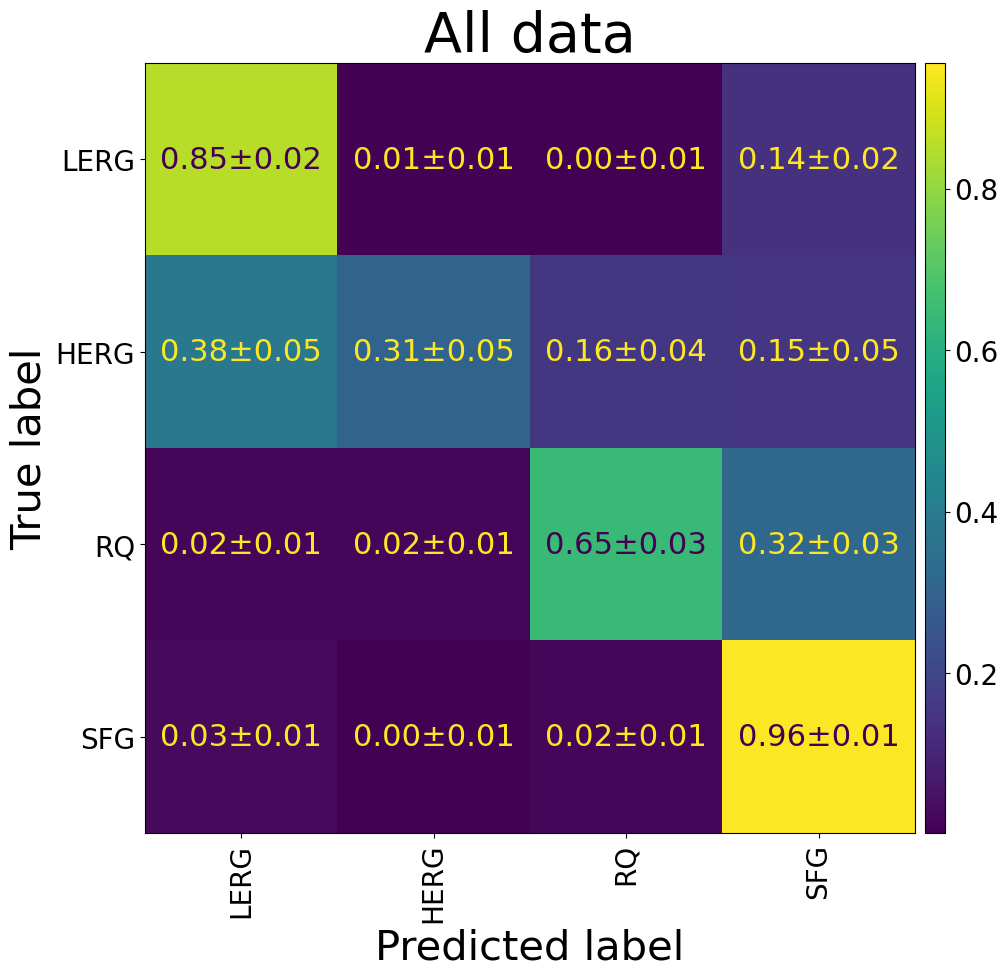

In [53]:
# Calculating the cm
cm_norm_row = np.array(cm_all).mean(axis=0)/np.array(cm_all).mean(axis=0).sum(axis=1)[:, np.newaxis]
cm_norm_row_std = np.array(cm_all).std(axis=0)/np.array(cm_all).mean(axis=0).sum(axis=1)[:, np.newaxis]

# Plotting
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm_row, display_labels=cm_labels)
disp.plot(ax=ax, colorbar=False)

# Because sklearn is dumb we have to manually set the errors and such to 4 decimals this way
digits = 2
for i in range(4):
    for j in range(4):
        disp.text_[i][j].set_text(f'{np.round(cm_norm_row[i][j],digits):.{digits}f}±{round_up(cm_norm_row_std[i][j],digits):.{digits}f}')
        disp.text_[i][j].set_fontsize(22)

# X and y-ticks font size    
ax.tick_params(axis='both', which='major', labelsize=20)

    
# Rotating x-ticks
plt.xticks(rotation = 90)

# Setting title and axes (font sizes)
plt.title("All data", fontsize=40)
plt.xlabel('Predicted label', fontsize=30)
plt.ylabel('True label', fontsize=30)

# Adjust size of colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cax.tick_params(axis='both', which='major', labelsize=20)
plt.colorbar(disp.im_,  cax=cax)

plt.plot()
plt.savefig("CM_all.pdf")
plt.show()

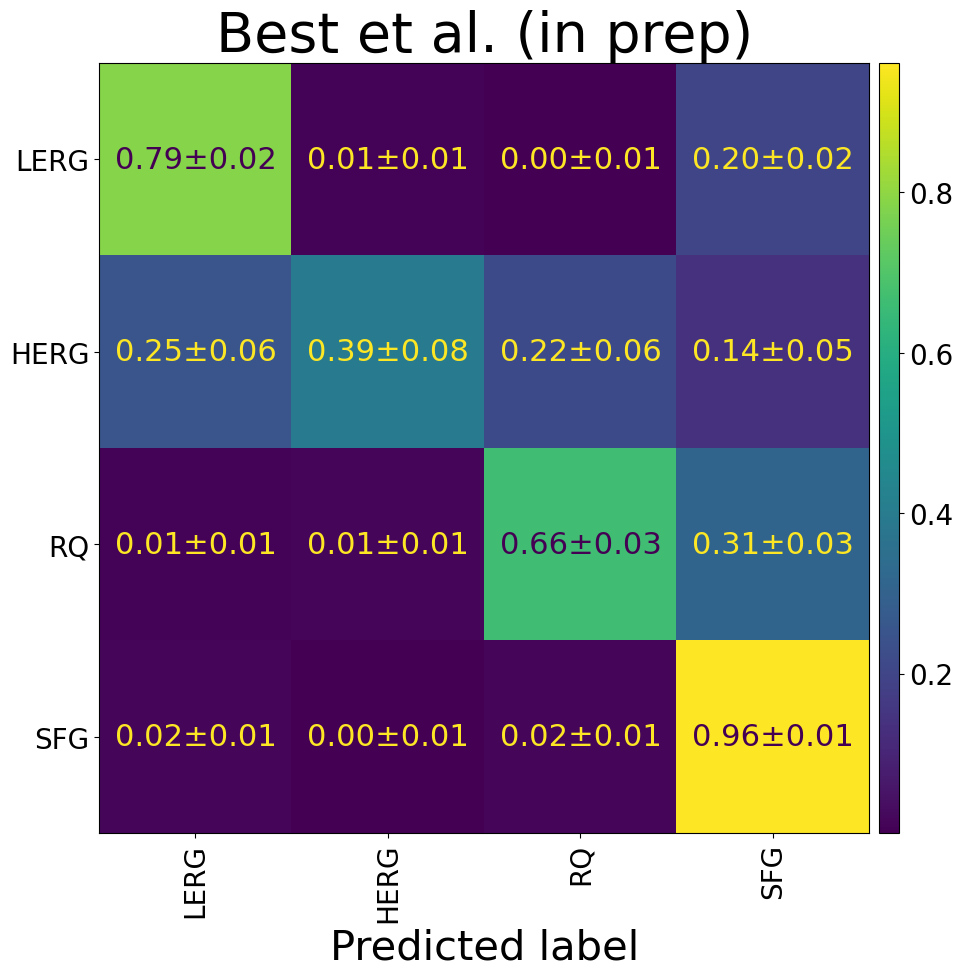

In [76]:
# Calculating the cm
cm_norm_row = np.array(cm_original).mean(axis=0)/np.array(cm_original).mean(axis=0).sum(axis=1)[:, np.newaxis]
cm_norm_row_std = np.array(cm_original).std(axis=0)/np.array(cm_original).mean(axis=0).sum(axis=1)[:, np.newaxis]

# Plotting
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm_row, display_labels=cm_labels)
disp.plot(ax=ax, colorbar=False)

# Because sklearn is dumb we have to manually set the errors and such to 4 decimals this way
digits = 2
for i in range(4):
    for j in range(4):
        disp.text_[i][j].set_text(f'{np.round(cm_norm_row[i][j],digits):.{digits}f}±{round_up(cm_norm_row_std[i][j],digits):.{digits}f}')
        disp.text_[i][j].set_fontsize(22)

# X and y-ticks font size    
ax.tick_params(axis='both', which='major', labelsize=20)

    
# Rotating x-ticks
plt.xticks(rotation = 90)

# Setting title and axes (font sizes)
plt.title("Best et al. (in prep)", fontsize=40)
plt.xlabel('Predicted label', fontsize=30)
plt.ylabel('', fontsize=30)

# Adjust size of colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cax.tick_params(axis='both', which='major', labelsize=20)
plt.colorbar(disp.im_,  cax=cax)

plt.plot()
plt.savefig("CM_original.pdf")
plt.show()

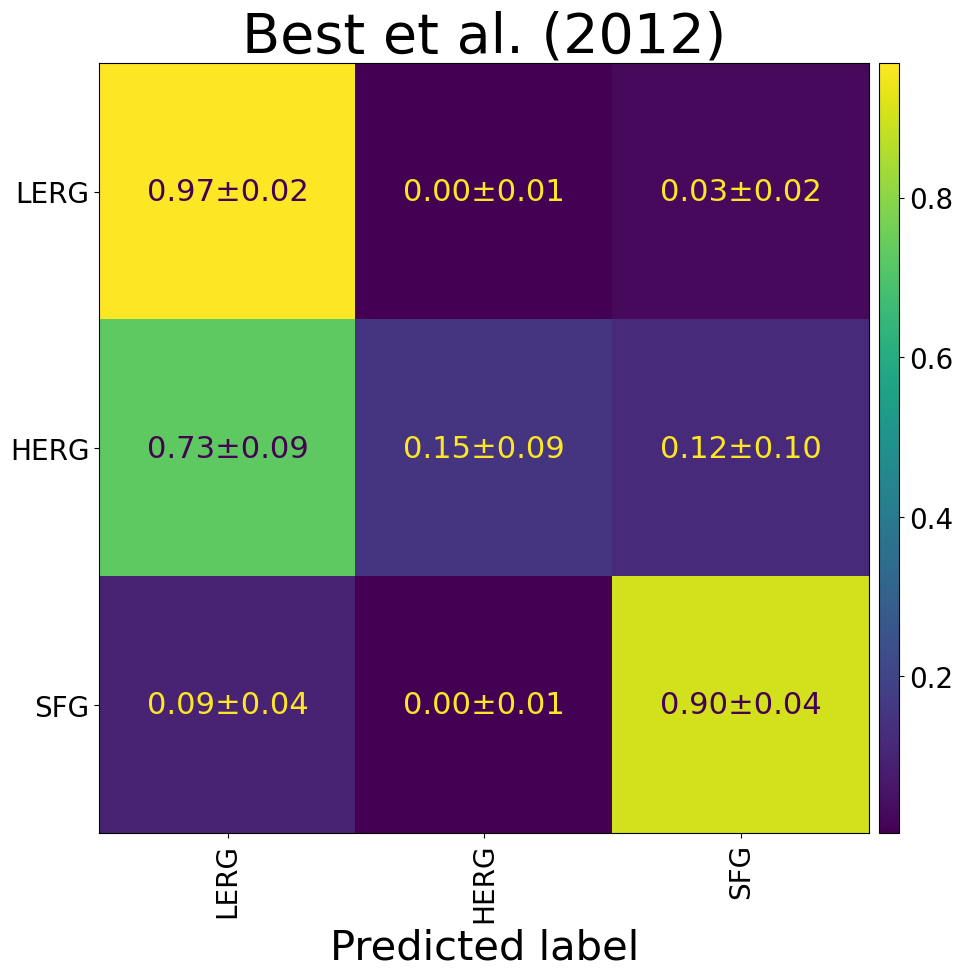

In [55]:
## Calculating the cm
cm_norm_row = np.array(cm_BH).mean(axis=0)/np.array(cm_BH).mean(axis=0).sum(axis=1)[:, np.newaxis]
cm_norm_row_std = np.array(cm_BH).std(axis=0)/np.array(cm_BH).mean(axis=0).sum(axis=1)[:, np.newaxis]

# Plotting
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm_row, display_labels=['LERG', 'HERG', 'SFG'])
disp.plot(ax=ax, colorbar=False)

# Because sklearn is dumb we have to manually set the errors and such to 4 decimals this way
digits = 2
for i in range(3):
    for j in range(3):
        disp.text_[i][j].set_text(f'{np.round(cm_norm_row[i][j],digits):.{digits}f}±{round_up(cm_norm_row_std[i][j],digits):.{digits}f}')
        disp.text_[i][j].set_fontsize(22)

# X and y-ticks font size    
ax.tick_params(axis='both', which='major', labelsize=20)

    
# Rotating x-ticks
plt.xticks(rotation = 90)

# Setting title and axes (font sizes)
plt.title("Best et al. (2012)", fontsize=40)
plt.xlabel('Predicted label', fontsize=30)
plt.ylabel('', fontsize=30)

# Adjust size of colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cax.tick_params(axis='both', which='major', labelsize=20)
plt.colorbar(disp.im_,  cax=cax)

plt.plot()
plt.savefig("CM_BH.pdf")
plt.show()

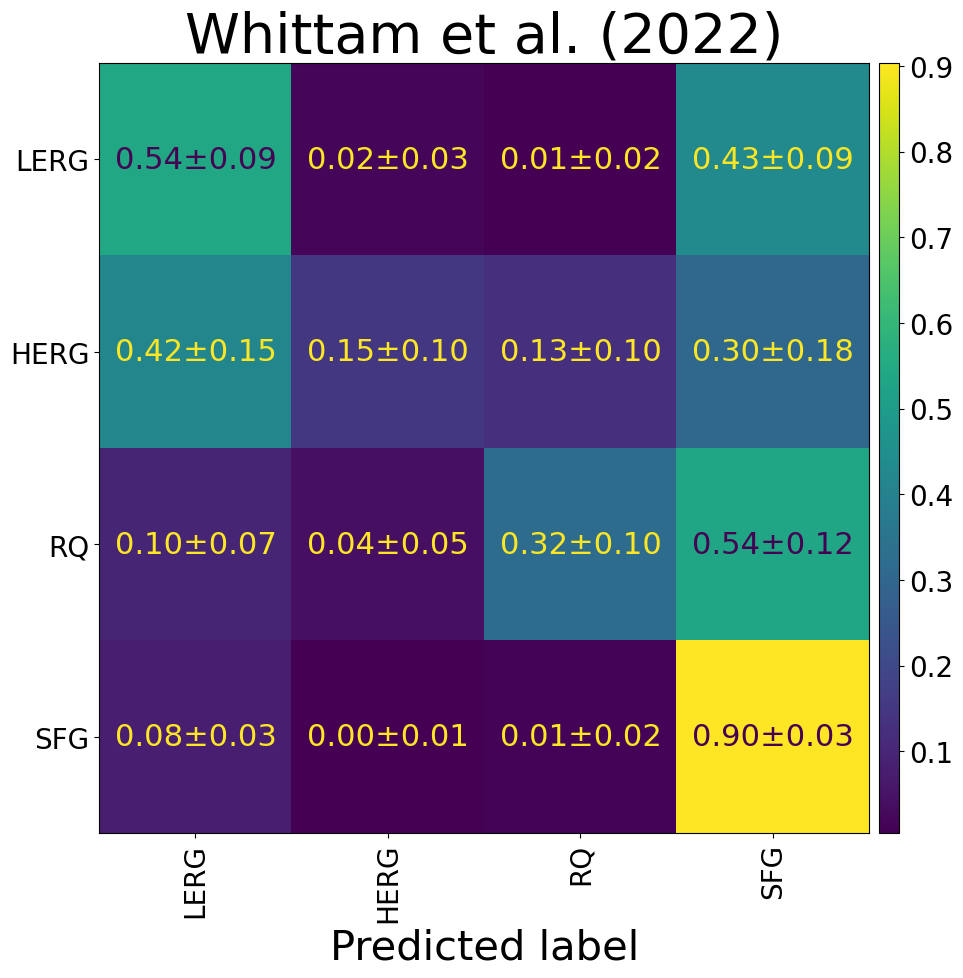

In [56]:
# Calculating the cm
cm_norm_row = np.array(cm_MIGHTEE).mean(axis=0)/np.array(cm_MIGHTEE).mean(axis=0).sum(axis=1)[:, np.newaxis]
cm_norm_row_std = np.array(cm_MIGHTEE).std(axis=0)/np.array(cm_MIGHTEE).mean(axis=0).sum(axis=1)[:, np.newaxis]

# Plotting
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm_row, display_labels=cm_labels)
disp.plot(ax=ax, colorbar=False)

# Because sklearn is dumb we have to manually set the errors and such to 4 decimals this way
digits = 2
for i in range(4):
    for j in range(4):
        disp.text_[i][j].set_text(f'{np.round(cm_norm_row[i][j],digits):.{digits}f}±{round_up(cm_norm_row_std[i][j],digits):.{digits}f}')
        disp.text_[i][j].set_fontsize(22)

# X and y-ticks font size    
ax.tick_params(axis='both', which='major', labelsize=20)
    
# Rotating x-ticks
plt.xticks(rotation = 90)

# Setting title and axes (font sizes)
plt.title("Whittam et al. (2022)", fontsize=40)
plt.xlabel('Predicted label', fontsize=30)
plt.ylabel('', fontsize=30)

# Adjust size of colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cax.tick_params(axis='both', which='major', labelsize=20)
plt.colorbar(disp.im_,  cax=cax)

plt.plot()
plt.savefig("CM_MIGHTEE.pdf")
plt.show()

## SHAP

In [57]:
import shap
shap.initjs()

In [58]:
mapping = {'Total_flux': 'Total 150 MHz',
           'Peak_flux': 'Peak 150 MHz', 
           'NUV_flux_corr': 'NUV', 
           'u_flux_corr': 'u',
           'Bw_flux_corr': r'$B_w$', 
           'R_flux_corr': 'R', 
           'I_flux_corr': 'I', 
           'z_flux_corr': 'z',
           'y_flux_corr': 'y', 
           'J_flux_corr': 'J', 
           'H_flux_corr': 'H', 
           'K_flux_corr': 'K',
           'Ks_flux_corr': r'$K_s$', 
           'ch1_flux_corr': 'ch1', 
           'ch2_flux_corr': 'ch2', 
           'ch3_flux_corr': 'ch3',
           'ch4_flux_corr': 'ch4', 
           'F_MIPS_24': 'MIPS24', 
           'F_PACS_100': 'PACS100', 
           'F_PACS_160': 'PACS160', 
           'F_SPIRE_250': 'SPIRE250',
           'F_SPIRE_350': 'SPIRE350', 
           'F_SPIRE_500': 'SPIRE500', 
           'Z_BEST': 'Redshift', 
           'g_flux_corr': 'g',
           'nb921_hsc_flux_corr': 'NB921'}

In [59]:
shap_values = shap.TreeExplainer(model, check_additivity=False).shap_values(X_train, check_additivity=False)

In [60]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22, "axes.labelsize": 200})

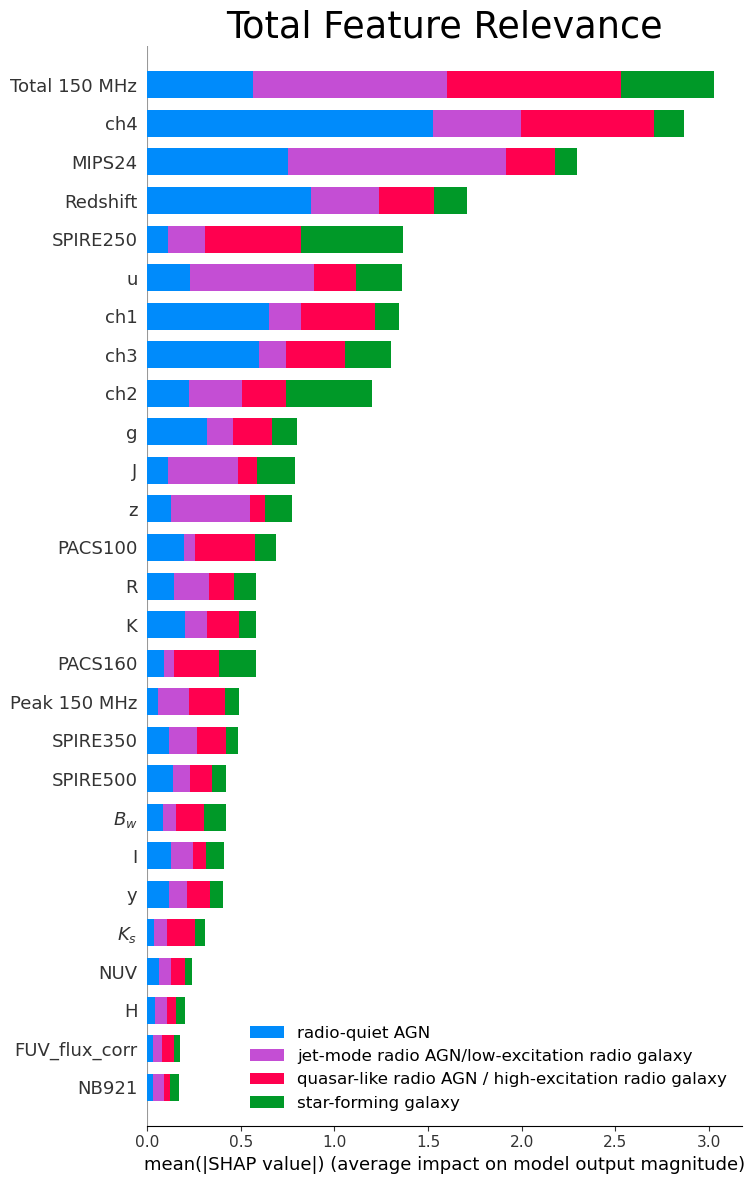

In [61]:
shap.summary_plot(shap_values, X_train.rename(columns=mapping), class_names=labels, max_display=999, show=False)
plt.title("Total Feature Relevance")
plt.tight_layout()
plt.savefig("Total_feature_relevance.pdf")

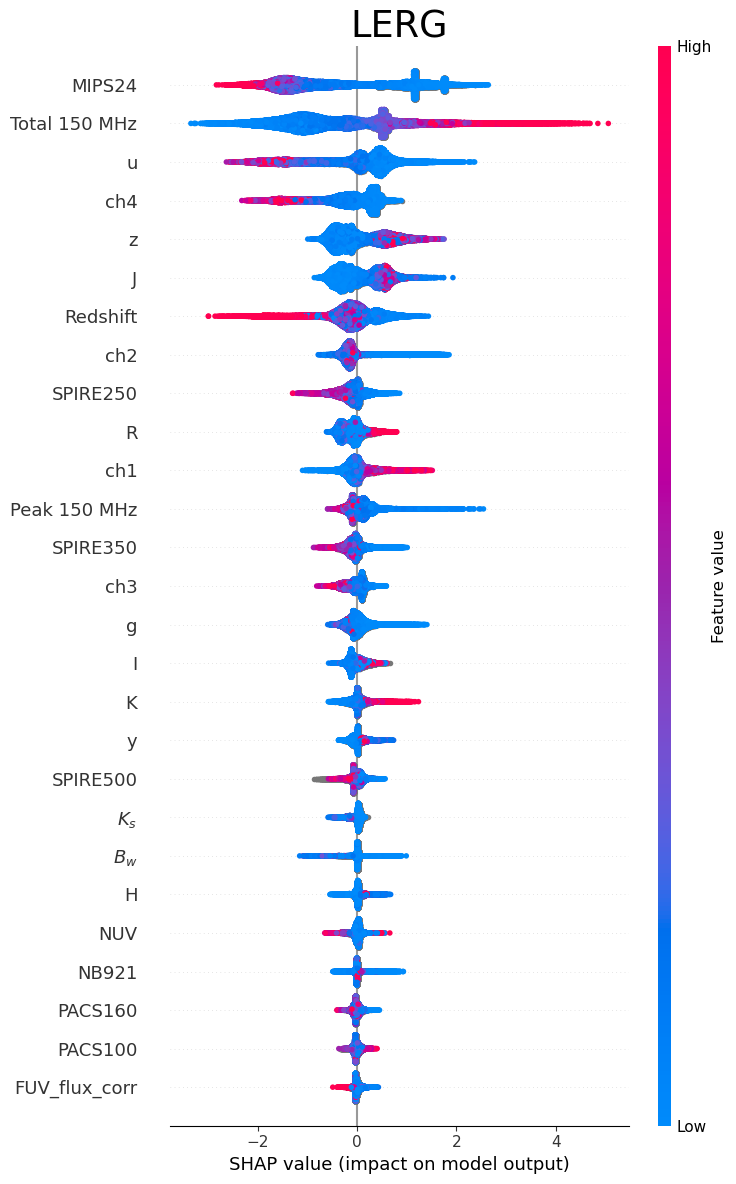

In [62]:
shap.summary_plot(shap_values[0], X_train.rename(columns=mapping), show=False, max_display=999)
plt.title('LERG')
plt.tight_layout()
plt.savefig("LERG_relevance.pdf")
plt.show()

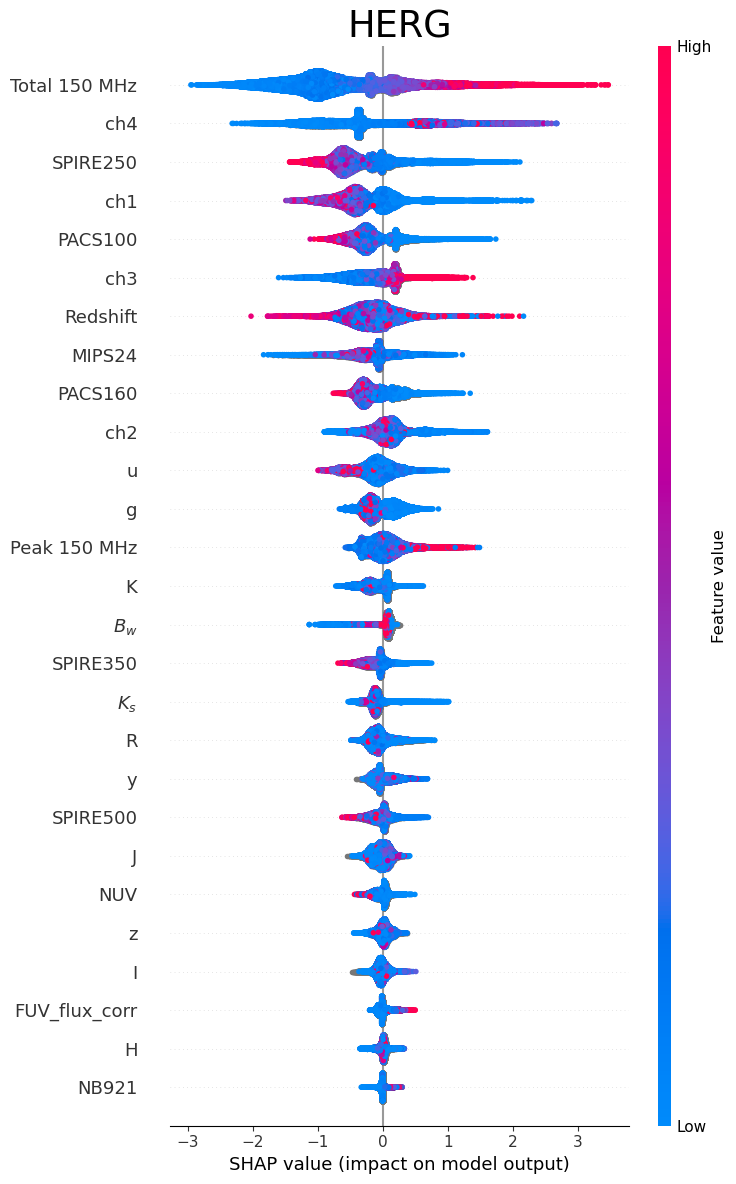

In [63]:
shap.summary_plot(shap_values[1], X_train.rename(columns=mapping), show=False, max_display=999)
plt.title('HERG')
plt.tight_layout()
plt.savefig("HERG_relevance.pdf")
plt.show()

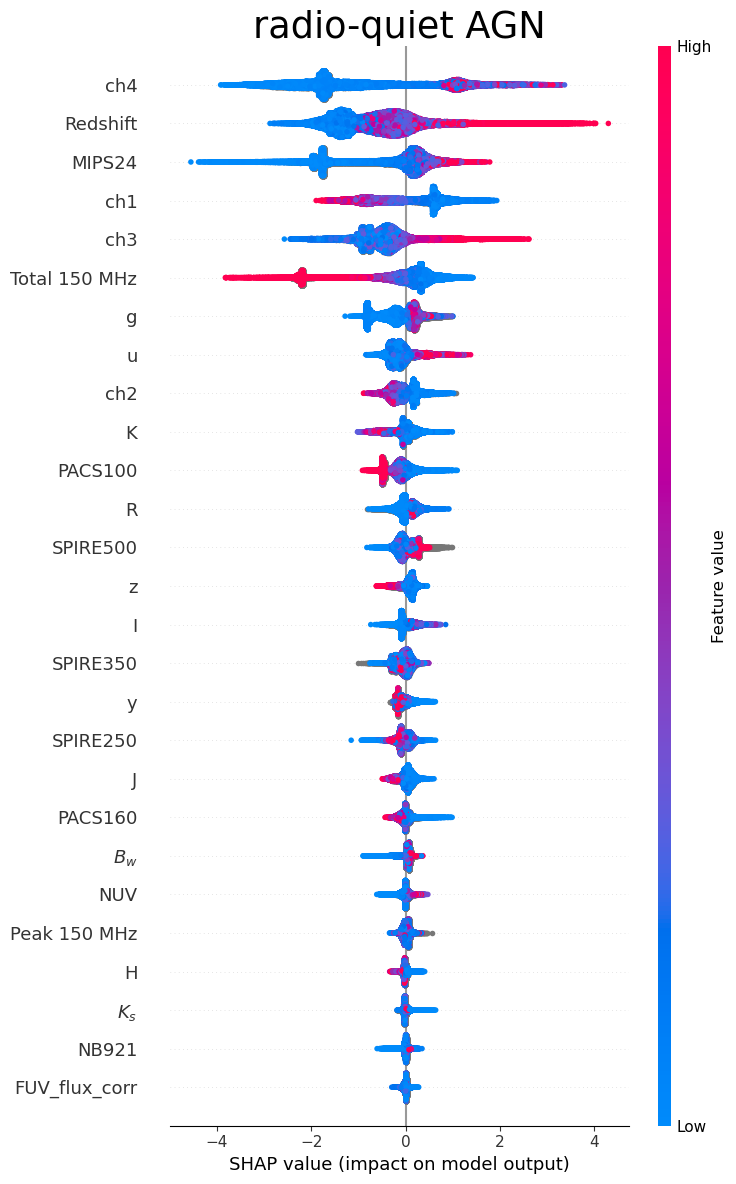

In [64]:
shap.summary_plot(shap_values[2], X_train.rename(columns=mapping).rename(columns=mapping), show=False, max_display=999)
plt.title(labels[2])
plt.tight_layout()
plt.savefig("RQ_relevance.pdf")
plt.show()

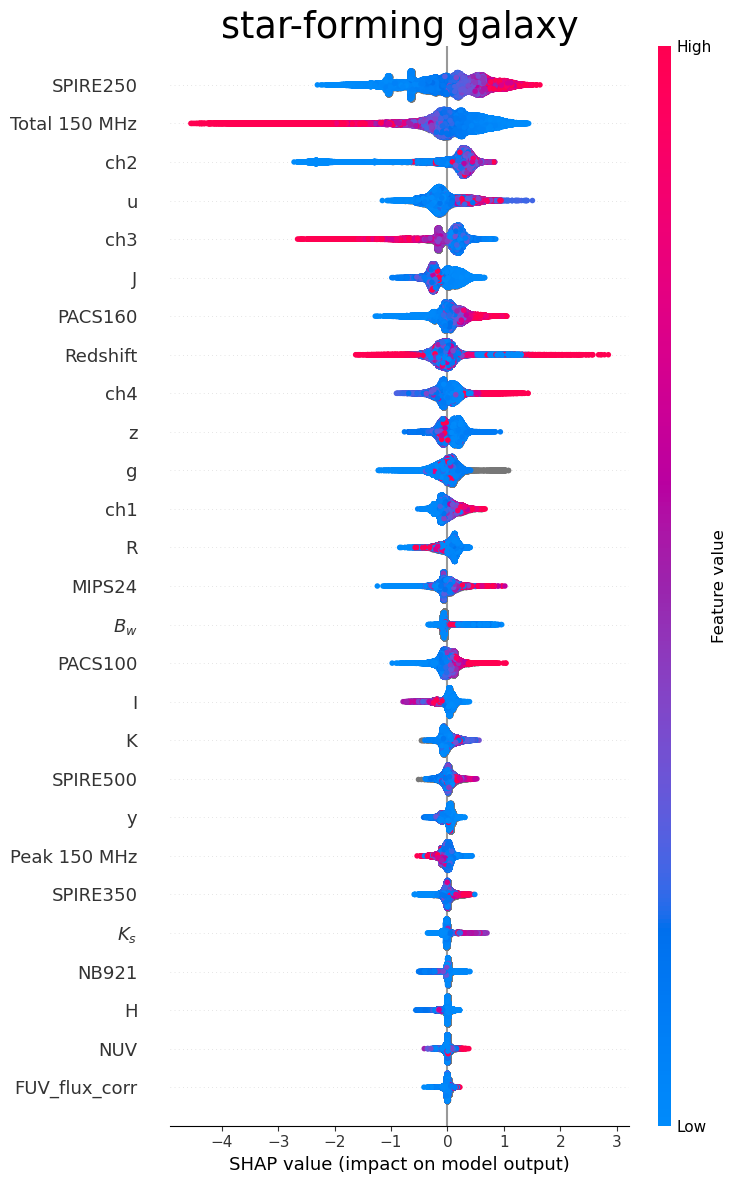

In [65]:
shap.summary_plot(shap_values[3], X_train.rename(columns=mapping).rename(columns=mapping), show=False, max_display=999)
plt.title(labels[3])
plt.tight_layout()
plt.savefig("SFG_relevance.pdf")
plt.show()